# Twitter Sentiment Analysis using NLP & LSTM

- By Sachin Saj

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin')
data.columns = ['Sentiment','ID','Date','Query','User_ID','Text']
print('Length of Data',len(data))
print('Shape of the data',data.shape)
data.head()

Length of Data 1599999
Shape of the data (1599999, 6)


,Sentiment,ID,Date,Query,User_ID,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
data = data.drop(['ID','Date','Query','User_ID'],axis=1)
data['Sentiment'] = data['Sentiment'].map({0:'Negative',4:'Postive'})
data.head()

,Sentiment,Text
0,Negative,is upset that he can't update his Facebook by ...
1,Negative,@Kenichan I dived many times for the ball. Man...
2,Negative,my whole body feels itchy and like its on fire
3,Negative,"@nationwideclass no, it's not behaving at all...."
4,Negative,@Kwesidei not the whole crew


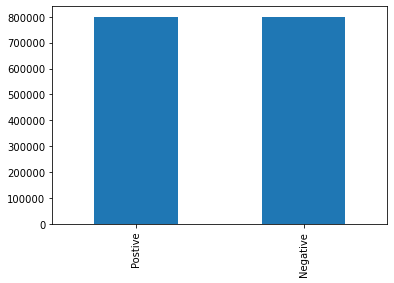

In [4]:
data['Sentiment'].value_counts().plot(kind='bar')

### Text Preprocessing

- Stemming/Lematization (Cutting the word / reducing the word to root word)
- Removal of Hyperlinks and Mentions
- Removal of stopwords & Puncations

In [5]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data['C_Text'] = data['Text'].apply(preprocess)

In [6]:
data.head()

,Sentiment,Text,C_Text
0,Negative,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,Negative,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...
2,Negative,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,Negative,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,Negative,@Kwesidei not the whole crew,whole crew


### Visualization

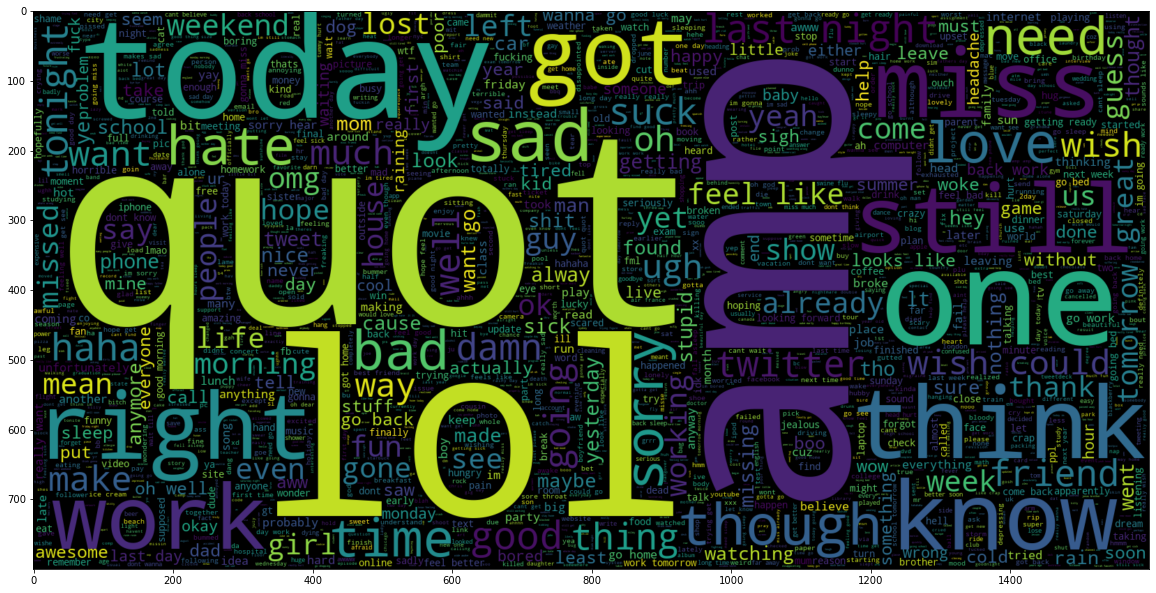

In [7]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Sentiment == 'Negative'].C_Text))
plt.imshow(wc , interpolation = 'bilinear')

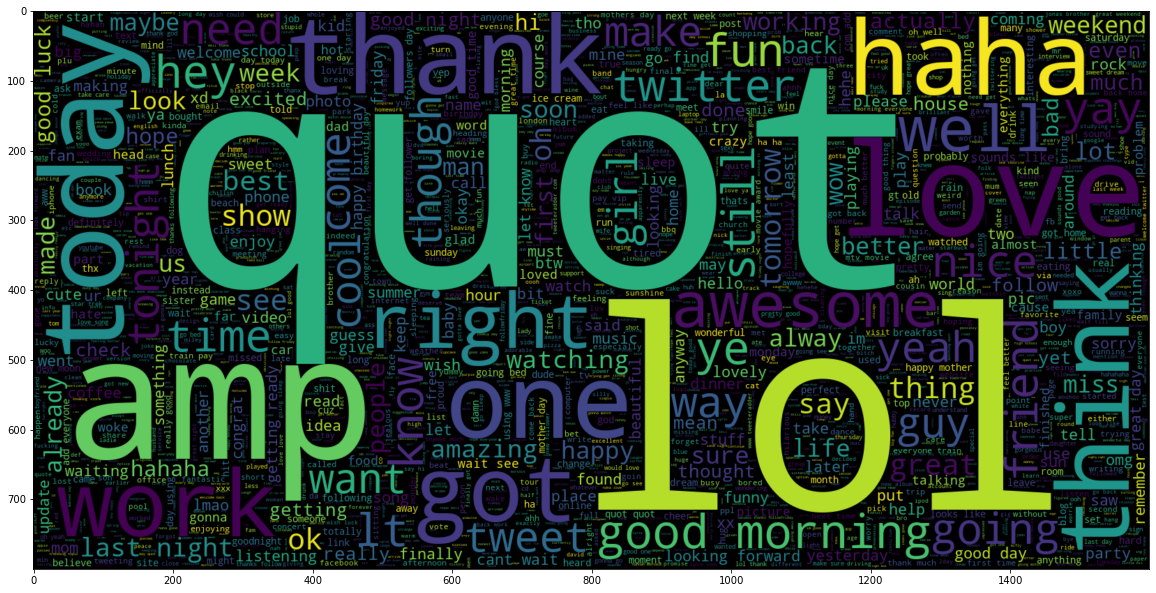

In [8]:


plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Sentiment == 'Postive'].C_Text))
plt.imshow(wc , interpolation = 'bilinear')

### Making the data ready for model

- Train test split
- Tokenization ( tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization )
- Sequence model ( We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH)
- Word Emdedding (Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.)

(We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification.)

In [9]:
X = data['C_Text']
Y = data['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_test.shape)

(1279999,)
(320000,)


In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index # Contains the index of each word
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size', vocab_size)

Vocabulary Size 290442


In [11]:
max_seq_len = 30
man_nb_words = 100000
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_seq_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_seq_len)

print(x_train.shape)
print(x_test.shape)

(1279999, 30)
(320000, 30)


In [12]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(y_train.shape)
print(y_test.shape)

(1279999, 1)
(320000, 1)


In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-08-23 07:02:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-23 07:02:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-23 07:02:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [16]:
glove_emb = '/kaggle/working/glove.6B.300d.txt'
embedding_dim = 300
lr = 1e-3
batch_size = 1024
epochs = 15

In [17]:
import tensorflow as tf

embedding_index = {}

f = open(glove_emb)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found word vectors', len(embedding_index))

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                                           input_length=max_seq_len, trainable=False)

Found word vectors 400000


In [18]:
sequence_input = Input(shape=(max_seq_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [20]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=1000, epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/15
1280/1280 [==============================] - 319s 249ms/step - loss: 0.5187 - accuracy: 0.7395 - val_loss: 0.4817 - val_accuracy: 0.7663
Epoch 2/15
1280/1280 [==============================] - 327s 256ms/step - loss: 0.4876 - accuracy: 0.7621 - val_loss: 0.4734 - val_accuracy: 0.7729
Epoch 3/15
1280/1280 [==============================] - 328s 256ms/step - loss: 0.4773 - accuracy: 0.7689 - val_loss: 0.4677 - val_accuracy: 0.7743
Epoch 4/15
1280/1280 [==============================] - 326s 255ms/step - loss: 0.4710 - accuracy: 0.7727 - val_loss: 0.4631 - val_accuracy: 0.7782
Epoch 5/15
1280/1280 [==============================] - 328s 256ms/step - loss: 0.4662 - accuracy: 0.7758 - val_loss: 0.4636 - val_accuracy: 0.7793
Epoch 6/15
1280/1280 [==============================] - 325s 254ms/step - loss: 0.4630 - accuracy: 0.7779 - val_loss: 0.4625 - val_accuracy: 0.7799
Epoch 7/15
1280/1280 [==============================] - 330s 258ms/step - loss: 0.4603 - accuracy: 0.7795 - val_

In [22]:
Score = model.evaluate(x_test,y_test)
print(' Test Accuracy ', Score[1])

10000/10000 [==============================] - 181s 18ms/step - loss: 0.4569 - accuracy: 0.7836
 Test Accuracy  0.7835562229156494
